# Egecentric Stochastic Block Model

This notebook summarizes the Python classes which help us deal with the parameters of an SBM of the type we have been defining, to be learnt from egocentric social surveys such as Understanding Society. 

## `EgocentricSBM` Class

`EgocentricSBM` stores the SBM's parameters. It consists of $d$ dimensions, each of which have $k_i$ number of blocks or communities (that is, of shape $(k_1,k_2,\dots k_d)$). Corresponding to every $j$th community in dimension $i$ we have the parameters

1. $\pi_{ij}$, which refers to the proportion of population belonging to $j$ (along $i$). 
2. $\rho_{ij}$, which refers to the proportion of friends of people in community $j$ (along $i$) from within community $j$ (along $i$).
3. $\omega_{ij}$, which refers to the mean (out)degree of population belonging to $j$ (along $i$).

Clearly, these parameters must respect the following constraints:

1. $0<\pi_{ij}<1$, $\sum_j\pi_{ij}=1$
2. $0\le\rho_{ij}\le1$
3. $0\le\omega_{ij}$, $\sum_j\omega_{ij}\pi_{ij}=\omega$, where $\omega$ is the mean (out)degree of the entire population

A community $j$ is said to be homophilous if $\pi_{ij}<\rho_{ij}$, heterophilous if $\pi_{ij}>\rho_{ij}$ and ambiphilous if $\pi_{ij}=\rho_{ij}$.

Under a "directed" SBM, the "affinity" from community $u$ to $v$ along dimension $i$ is given by $\psi_{uu}^i = \omega_{iu}\frac{\rho_{iu}}{\pi_{iu}}$, $\psi_{vv}^i = \omega_{iu}\frac{1-\rho_{iu}}{1-\pi_{iu}}$. Below, we write some key properties of the members of this SBM:

1. The mean preference of a community to itself, the mean "homophily", along dimension $i$ is given by $\sum_{j}\frac{\rho_{ij}}{\pi_{ij}}\pi_{ij}^2 = \sum_{j}\rho_{ij}\pi_{ij}$.
2. Similarly, the mean preference of a communnity to any other community, mean "heterophily" is given by $\sum_{j}\frac{1-\rho_{ij}}{1-\pi_{ij}}(1-\pi_{ij})\pi_{ij} = \sum_{j}(1-\rho_{ij})\pi_{ij} = 1-\sum_{j}\rho_{ij}\pi_{ij}$.
3. The mean affinity of a community to itself, the mean "homoffinity", is given by $\sum_{j}\omega_{ij}\rho_{ij}\pi_{ij}$.
4. The mean "heteroffinity" is given by $\sum_{j}\omega_{ij}(1-\rho_{ij})\pi_{ij} = \omega - \sum_{j}\omega_{ij}\rho_{ij}\pi_{ij}$, where $\omega$ refers to the mean (out)degree, which is the same across any dimenison $i$.

Let's demonstrate these ideas below, by creating an `EgocentricSBM` of shape `(2,4)`.

In [1]:
from egosbm import EgocentricSBM

In [4]:
ego_sbm = EgocentricSBM([2,4], name='test')
print(ego_sbm)

name:     test
ndim:     2
shape:    (2, 4)
          
|dims|    |blocks|
0         ('0', '1')
1         ('0', '1', '2', '3')
          
|dims|    |pi|
0         (0.5, 0.5)
1         (0.25, 0.25, 0.25, 0.25)
          
|dims|    |rho|
0         (0.5, 0.5)
1         (0.25, 0.25, 0.25, 0.25)
          
|dims|    |omega|
0         (1.0, 1.0)
1         (1.0, 1.0, 1.0, 1.0)


The SBM is initialized with the least-informative assumptions: equi-proportined population, ambiphily, and mean-degree of 1. We can use some class methods to initialize a more interesting SBM.

In [5]:
ego_sbm.set_pi()
ego_sbm.set_omega(5)
ego_sbm.set_rho()

Now, we can print the SBM, as we did before. However, since the `EgocentricSBM` class has been written as an iterable, we can iterate over its dimensions just as we could with any iterable Python object.

In [6]:
print(len(ego_sbm))
for i in ego_sbm: print(i)

2
{'index': 0, 'name': '0', 'blocks': ('0', '1'), 'pi': (0.23390849643792677, 0.7660915035620732), 'rho': (0.22429734213554856, 0.2550767994927742), 'omega': (6.959756269066645, 4.4016333033968476)}
{'index': 1, 'name': '1', 'blocks': ('0', '1', '2', '3'), 'pi': (0.3498702909593375, 0.18296259781503849, 0.1033987376026092, 0.36376837362301473), 'rho': (0.157919504577722, 0.19296765738380686, 0.35755170016118765, 0.5905373467780849), 'omega': (4.54310678771881, 8.489346252876018, 2.704182640519931, 4.336990528215217)}


This SBM looks more realistic, and obeys a mean-degree of $5$. We can confirm that and other properties by using the following definitions and methods.

In [7]:
print('mean degree', ego_sbm.mean_omega())
print('mean homophily', ego_sbm.mean_homophily())
print('mean heterophily', ego_sbm.mean_heterophily())
print('mean homoffinity', ego_sbm.mean_homoffinity())
print('mean heteroffinity', ego_sbm.mean_heteroffinity())

mean degree 5.0
mean homophily [0.24787722290117026, 0.3423464115294333]
mean heterophily [0.7521227770988297, 0.6576535884705668]
mean homoffinity [1.2252766991458302, 1.5823782987336288]
mean heteroffinity [3.7747233008541703, 3.417621701266372]


In [8]:
print(ego_sbm.ishomophilous())

((False, False), (False, True, True, True))


Clearly, not all communities are homophilous, which is quite unlikely for a social network. Let us enforce homophily by setting a random $\rho$ such that $\pi<\rho<=1$.

In [9]:
ego_sbm.enforce_homophily()
print(ego_sbm.ishomophilous())

((True, True), (True, True, True, True))


Now we might be interested in making further changes to this SBM, but retain a base version of the original. `EgocentricSBM` provides a `copy()` method to return a copy of the SBM, and `save()` and `load()` methods to store the SBM to a `.ego` file. 

In [10]:
ego_sbm.save('some_egosbm')

In [11]:
ego_copy = ego_sbm.copy()
ego_load = EgocentricSBM(filepath='some_egosbm.ego')

`EgocentricSBM` also permits comparison operators, akin to set arithmetic. Two SBMs are considered to be the same if all of their parameters are exactly identical, modulo any sorting of dimensions or blocks within dimensions: in essence defining an equivalent class. One SBM is considered $<$ the other if it is its subset, and vice-versa: in essence the former contains the same model sliced into lower dimensions.

In [12]:
print(ego_copy == ego_load == ego_sbm)

True


Not only is `EgocentricSBM` an iterable, it is made to behave both like a `list`, whose indices are given by dimension number, and a `dict`, whose keys are given by dimension name, allowing for a flexible mode of indexing.

In [13]:
print(ego_sbm[1] == ego_sbm['1'])

True


Being implemented as a list, the SBM can be sorted into a canonical order. Dimensions are sorted by number of blocks, and blocks are sorted by pi, followed by rho, followed by omega.

In [14]:
ego_sbm.sort()
print(ego_sbm)

name:     test
ndim:     2
shape:    (4, 2)
          
|dims|    |blocks|
1         ('3', '0', '1', '2')
0         ('1', '0')
          
|dims|    |pi|
1         (0.36376837362301473, 0.3498702909593375, 0.18296259781503849, 0.1033987376026092)
0         (0.7660915035620732, 0.23390849643792677)
          
|dims|    |rho|
1         (0.4233416218251464, 0.702800039276387, 0.7076224136491357, 0.4207769510699945)
0         (0.905236364777181, 0.531123003476457)
          
|dims|    |omega|
1         (4.336990528215217, 4.54310678771881, 8.489346252876018, 2.704182640519931)
0         (4.4016333033968476, 6.959756269066645)


We can also use other list-like methods, such as `insert(index, value)`/`insert(key, value)`, or `append(value)`, or `pop(index)`/`pop(key)` or `del(index)`/`del(key)`

In [15]:
ego_sbm.insert(0, {'name':'some_dim1', 'num':3})
ego_sbm.insert('some_dim2', {'num':7})
ego_sbm.append({'num':2, 'pi':(0.1,0.9)})
ego_sbm.insert('copy_dim1', ego_sbm['1'])
print(ego_sbm)

name:        test
ndim:        6
shape:       (3, 4, 4, 2, 7, 2)
             
|dims|       |blocks|
some_dim1    ('0', '1', '2')
copy_dim1    ('3', '0', '1', '2')
1            ('3', '0', '1', '2')
0            ('1', '0')
some_dim2    ('0', '1', '2', '3', '4', '5', '6')
2            ('0', '1')
             
|dims|       |pi|
some_dim1    (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
copy_dim1    (0.36376837362301473, 0.3498702909593375, 0.18296259781503849, 0.1033987376026092)
1            (0.36376837362301473, 0.3498702909593375, 0.18296259781503849, 0.1033987376026092)
0            (0.7660915035620732, 0.23390849643792677)
some_dim2    (0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285)
2            (0.1, 0.9)
             
|dims|       |rho|
some_dim1    (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
copy_dim1    (0.4233416218251464, 0.702800039276387, 0.70762

In [16]:
print(ego_copy==ego_sbm)
print(ego_copy<ego_sbm)

False
True


Since we have only inserted extra dimensions into `ego_sbm`, it is shown as a superset of `ego_copy`. However, if we were to remove one of the dimensions (say using `del` or `pop()`), this will no longer hold.

In [17]:
print(ego_sbm.pop('0'))
print(ego_copy<ego_sbm)

{'index': 3, 'name': '0', 'blocks': ('1', '0'), 'pi': (0.7660915035620732, 0.23390849643792677), 'rho': (0.905236364777181, 0.531123003476457), 'omega': (4.4016333033968476, 6.959756269066645)}
False


Much like lists and dicts, we can set one or more parameters of the SBM. The class implements an internal consistency check which ensures that only suitable parameters are accepted, which respect the model constraints.

In [18]:
ego_sbm.append(ego_copy['0'])
ego_sbm['0'] = {'pi':(0.5,0.5), 'omega':(ego_sbm.mean_omega(),)*2} #changing pi and omega for dimension number 0
ego_sbm[0] = {'rho':(0.4,0.7,0.9)} #changing rho for dimension "1"
for i in ego_sbm: print(i)

{'index': 0, 'name': 'some_dim1', 'blocks': ('0', '1', '2'), 'pi': (0.3333333333333333, 0.3333333333333333, 0.3333333333333333), 'rho': (0.4, 0.7, 0.9), 'omega': (5.0, 5.0, 5.0)}
{'index': 1, 'name': 'copy_dim1', 'blocks': ('3', '0', '1', '2'), 'pi': (0.36376837362301473, 0.3498702909593375, 0.18296259781503849, 0.1033987376026092), 'rho': (0.4233416218251464, 0.702800039276387, 0.7076224136491357, 0.4207769510699945), 'omega': (4.336990528215217, 4.54310678771881, 8.489346252876018, 2.704182640519931)}
{'index': 2, 'name': '1', 'blocks': ('3', '0', '1', '2'), 'pi': (0.36376837362301473, 0.3498702909593375, 0.18296259781503849, 0.1033987376026092), 'rho': (0.4233416218251464, 0.702800039276387, 0.7076224136491357, 0.4207769510699945), 'omega': (4.336990528215217, 4.54310678771881, 8.489346252876018, 2.704182640519931)}
{'index': 3, 'name': 'some_dim2', 'blocks': ('0', '1', '2', '3', '4', '5', '6'), 'pi': (0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.1428571428571428

More interestingly, we can do some arithmetic on `EgocentricSBM` objects which can simplify downstream processing.
1. "Addition" is defined for 2 (or more) `EgocentricSBM`s, which stands for concatenation of their respective dimensions. This would be equivalent to appending operations applied iteratively. Note that the additive identity is given by the empty `EgocentricSBM()`.
2. "Multiplication" is defined for:
    1. 2 (or more) `EgocentricSBM`s, where it stands for an outer-product of their respective dimensions. This would be equivalent to incorporating the Kronecker structure in SBMs dimensions.
    2. An `EgocentricSBM` and a `float` or `int`, which stands for scaling the mean affinity (degree) induced by the SBM. This would be equivalent to using the `scale()` method of `EgocentricSBM`, which can, in particular, scale the SBM to have unit mean affinity. This operation can be useful for appropriate sum and product of `EgocentricSBM`s, since a sum would require would SBMs to have the same mean affinity, and a product leads to multiplication of mean affinities which might require rescaling (say to the square root of mean affinities).
3. "Exponentiation" is defined for an `EgocentricSBM` and a non-negative `int`, where it stands for repeated outer-products of the `EgocentricSBM` with itself. (This would be akin to growing a [Kronecker Product Graph Model](https://cs.stanford.edu/people/jure/pubs/kronecker-jmlr10.pdf).) Note that the multiplicative identity is given by the unit `EgocentricSBM(1)` with mean affinity $1$, and thus `some_egocentricsbm**0 == EgocentricSBM(1)`.

Let's explore these operations taking an example of the SBM learnt from [Understanding Society](https://www.understandingsociety.ac.uk/)'s surveys about the UK.

In [19]:
uk_ego = EgocentricSBM(filepath='usoc_wave3.ego')
print(uk_ego)

name:         usoc_wave3
ndim:         6
shape:        (8, 5, 5, 5, 4, 2)
              
|dims|        |blocks|
ethnicity     ('british-white', 'indian-pakistani', 'other-white', 'black', 'bangladeshi', 'chinese-mixed', 'other-asian', 'other-ethnicity')
employment    ('employed', 'retired', 'student', 'housework', 'unemployed')
age           (40.0, 20.0, 60.0, 0.0, 80.0)
education     ('level-4', 'level-0', 'level-2', 'level-3', 'level-1')
income        ('C2', 'AB', 'DE', 'C1')
sex           ('female', 'male')
              
|dims|        |pi|
ethnicity     (0.8027865074376702, 0.05537397862979258, 0.048711502199874294, 0.04714016341923319, 0.01743138487324534, 0.010496543054682589, 0.010119421747328725, 0.007940498638173057)
employment    (0.5735927117723265, 0.23473609427890843, 0.07365539721676627, 0.06191232395837686, 0.05610347277362197)
age           (0.3515431788478938, 0.3012968734291746, 0.23532723434201266, 0.06789986930732884, 0.04393284407359003)
education     (0.3238752988

This model has 6 dimensions. Say we are only interested in looking at `sex` and `income`.

In [20]:
uk_ego_sex = EgocentricSBM(uk_ego['sex'], name='sex')
uk_ego_inc = EgocentricSBM(uk_ego['income'], name='inc')
uk_ego_sex_plus_inc = uk_ego_sex + uk_ego_inc #only SBMs with same mean affinity can be added
uk_ego_sex_times_inc = (uk_ego_sex * uk_ego_inc)/uk_ego.mean_omega() #dividing by mean affinity to preserve original mean affinity
uk_ego_sex_sqr = uk_ego_sex**2/uk_ego.mean_omega()
print(uk_ego_sex_plus_inc)
print(uk_ego_sex_times_inc)
print(uk_ego_sex_sqr)

name:     sex + inc
ndim:     2
shape:    (2, 4)
          
|dims|    |blocks|
sex       ('female', 'male')
income    ('C2', 'AB', 'DE', 'C1')
          
|dims|    |pi|
sex       (0.541939764365274, 0.458060235634726)
income    (0.3025995697541165, 0.24942198274995475, 0.2270250708699411, 0.22095337662598766)
          
|dims|    |rho|
sex       (0.8688629836120967, 0.7988007847805481)
income    (0.6074082073434125, 0.5988610812396129, 0.5743879472693032, 0.6181952494601659)
          
|dims|    |omega|
sex       (3.1146967524702496, 3.478370014190206)
income    (3.009819387477732, 3.721063104802218, 3.126741884090977, 3.3153927609540017)
name:           (sex * inc)
ndim:           1
shape:          (8,)
                
|dims|          |blocks|
(sex,income)    ('(female,C2)', '(female,AB)', '(female,DE)', '(female,C1)', '(male,C2)', '(male,AB)', '(male,DE)', '(male,C1)')
                
|dims|          |pi|
(sex,income)    (0.1639907395295792, 0.13517169055902992, 0.12303391341226551

## `StochasticBlockModel` Class

This class takes parameters from an `EgocentricSBM` and turns it into an appropriate SBM with full block matrix $\Psi \propto \bigotimes_i\Psi^i$. Recall that we have 3 model modes:

1. The "Full" (`full`) SBM Model uses block matrices $\Psi^i$s which have different entires for different communities along a given dimension $i$, which means a model with $3*\Pi_i^dk_i$ number of parameters. More precisely,
    1. $\Psi_{uu}^i = \omega_{iu}\frac{\rho_{iu}}{\pi_{iu}}$
    2. $\Psi_{uv}^i = \omega_{iu}\frac{1-\rho_{iu}}{1-\pi_{iu}}$
    3. $\Psi = \frac{1}{\omega^{d-1}}\bigotimes_i\Psi^i$
2. The "Planted partition" (`pp`) SBM Model uses block matrices $\Psi^i$s which have same entries for different communities along a given dimension $i$, which means a model with $1+2d$ number of parameters. More precisely, we can use the model's mean properties such that the mean affinity of the model is preserved.
    1. $\Psi_{uu}^i = \omega\frac{\sum_u\rho_{iu}\pi_{iu}}{\sum_u\pi_{iu}^2}$
    2. $\Psi_{uv}^i = \omega\frac{1-\sum_u\rho_{iu}\pi_{iu}}{1-\sum_u\pi_{iu}^2}$
    3. $\Psi = \frac{1}{\omega^{d-1}}\bigotimes_i\Psi^i$
3. While the `pp` model preserves mean affinity, it doesn't preserve the mean homoffinity and mean heteroffinity separately. This is because we essentially have two degrees of freedom, one of which goes in keeping the mean degree "separate" from the homophily parameter. We can overcome this problem by marginalizing over $\omega_{iu}$, which means we absorb it, but this let's us preserve both mean homoffinity and mean heteroffinity of the network along that dimension $i$. We call this the "Planted partition collapsed" (`ppcollapsed`) SBM Model, which leads to a model with $2d$ number of parameters. More precisely,
    1. $\Psi_{uu}^i = \frac{\sum_u\omega_{iu}\rho_{iu}\pi_{iu}}{\sum_u\pi_{iu}^2}$
    2. $\Psi_{uv}^i = \frac{\omega-\sum_u\omega_{iu}\rho_{iu}\pi_{iu}}{1-\sum_u\pi_{iu}^2}$
    3. $\Psi = \frac{1}{\omega^{d-1}}\bigotimes_i\Psi^i$
    
### Notes

1. If every community along a dimension $i$ has the same mean degree, then `pp`==`ppcollapsed`.
2. If every community along a dimension $i$ has the same level of homophily or heterophily ($\rho_{ij}/\pi_{ij}$) as well, then `full`==`pp`==`ppcollapsed`.
3. The planted partition models have a symmetric block matrix, while the full model can be chosen to be directed or undirected, which renders the concept of in/out-(hetero)affinities.

In [21]:
model_full = ego_sbm.get_model('full', name='some_model_full')
model_pp = ego_sbm.get_model('pp', name='some_model_pp')
model_ppc = ego_sbm.get_model('ppcollapsed', name='some_model_ppc')
model_sexplusinc = uk_ego_sex_plus_inc.get_model(name='uk_sex_plus_inc')
model_sextimesinc = uk_ego_sex_times_inc.get_model(name='uk_sex_times_inc')

We can print out the parameters of these models.

In [22]:
print('full\n', model_full.params)
print('planted partition\n', model_pp.params)
print('planted partition collapsed\n', model_ppc.params)

full
 (((5.0, 1.2000000000000002, 0.8999999999999999), (5.0, 2.1, 0.45), (5.0, 2.7, 0.14999999999999994)), ((4.336990528215217, 1.163766980644308, 0.9063654717364947), (4.54310678771881, 2.0087445474416334, 0.4571394855376846), (8.489346252876018, 3.8675796151762616, 0.3578509203727685), (2.704182640519931, 4.069459268324534, 0.6460207822831312)), ((4.336990528215217, 1.163766980644308, 0.9063654717364947), (4.54310678771881, 2.0087445474416334, 0.4571394855376846), (8.489346252876018, 3.8675796151762616, 0.3578509203727685), (2.704182640519931, 4.069459268324534, 0.6460207822831312)), ((5.0, 1.0, 1.0), (5.0, 1.0, 1.0), (5.0, 1.0, 1.0), (5.0, 1.0, 1.0), (5.0, 1.0, 1.0), (5.0, 1.0, 1.0), (5.0, 1.0, 1.0)), ((5.0, 5.0, 0.5555555555555556), (5.0, 0.5555555555555556, 5.000000000000001)), ((5.0, 1.062246006952914, 0.937753993047086), (5.0, 1.810472729554362, 0.1895272704456381)))
planted partition
 (5.0, ((2.0, 0.5), (1.9165511465370701, 0.6092406201578053), (1.9165511465370701, 0.6092406201

We can save and load these models in `numpy`s binary format.

In [23]:
model_full.save()
model_full_load = EgocentricSBM.StochasticBlockModel(filepath='some_model_full.npz')

In [7]:
import numpy as np
d = tuple(np.array(('sahil','loomba')))
print(d)

('sahil', 'loomba')


In [1]:
from egosbm import EgocentricSBM

In [4]:
model_full_load = EgocentricSBM.StochasticBlockModel(filepath='some_model_full.npz')
model_full_load.meanomega

5.0

In [9]:
model_tmp = EgocentricSBM.StochasticBlockModel(filepath='sbm.npz')

KeyError: 'mode is not a file in the archive'

In [15]:
print(model_tmp)

name:	sbm
type:	full
ndim:	2
shape:	(2, 4)
pi:	((0.45255177964389914, 0.5474482203561009), (0.30603702044104375, 0.1844014881038014, 0.24153485692832244, 0.2680266345268324))
params:	(((9.766999043717888, 2.008088312858175, 0.16665696762073934), (1.0593279499711972, 1.4706316295089188, 0.43068073178126814)), ((4.3689616789458725, 2.2069838117634037, 0.46772127569772687), (11.666187991319433, 3.80663629416373, 0.3654378941831632), (4.848532084049004, 2.3098735704749735, 0.5828679428067473), (1.270709743546217, 2.6225756931131174, 0.4058615752923957)))


In [19]:
print(ego_copy)

name:     test
ndim:     2
shape:    (2, 4)
|dims|    |blocks|
0         ('0', '1')
1         ('0', '1', '2', '3')
|dims|    |pi|
0         (0.8523210467969118, 0.14767895320308824)
1         (0.03972240180831733, 0.28937431963679605, 0.46099769607447894, 0.20990558248040772)
|dims|    |rho|
0         (0.9107020018919408, 0.4647018491726733)
1         (0.772759465617555, 0.9364552776284027, 0.7877509988813005, 0.7854239196927765)
|dims|    |omega|
0         (4.719596142870127, 6.618335611481206)
1         (10.786269249958977, 2.443520660539291, 4.394721397407868, 8.75867563577439)


In [6]:
uk_sbm = uk_ego.get_model()#.generate_networkx(n=10)

In [7]:
uk_nx = uk_sbm.generate_networkx()

C:\Users\lenovo\Desktop\phd\dat\egosbm.py:733: RuntimeWarning: symmetrising the stochastic block matrix
  if self.directed: warn('symmetrising the stochastic block matrix', RuntimeWarning)


num nodes: 100
num communities: 90
mean degree: 3.04


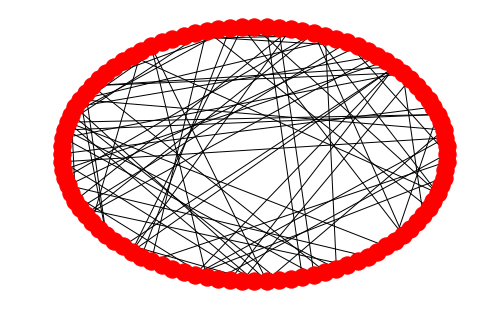

In [15]:
nx.draw_shell(uk_nx)
print('num nodes:', len(uk_nx))
print('num communities:', len(uk_nx.graph['partition']))
print('mean degree:', sum([x[1] for x in uk_nx.degree])/len(uk_nx))
plt.show()

In [3]:
import networkx as nx
import matplotlib.pyplot as plt

num nodes: 100
num communities: 8
mean degree: 4.58


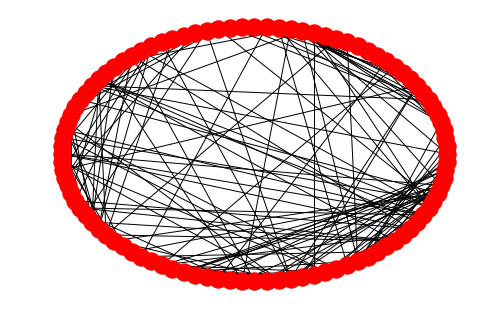

In [16]:
nx.draw_shell(tmp_nx)
print('num nodes:', len(tmp_nx))
print('num communities:', len(tmp_nx.graph['partition']))
print('mean degree:', sum([x[1] for x in tmp_nx.degree])/len(tmp_nx))
plt.show()

In [ ]:
len(tmp_nx.graph['partition'])

In [6]:
tmp_nx

{'sizes': [4, 27, 45, 15, 1, 3, 5],
 'p': [1.0,
  0.0805593190822485,
  0.07650578450978499,
  0.3338806841057248,
  1.0,
  0.33269207241436527,
  0.3159518760860011],
 'directed': False,
 'selfloops': False}

In [1]:
from egosbm import EgocentricSBM
tmp = EgocentricSBM(filepath='some_egosbm.ego', name='some')
print(tmp)

name:     some
ndim:     2
shape:    (2, 4)
|dims|    |blocks|
0         ('0', '1')
1         ('0', '1', '2', '3')
|dims|    |pi|
0         (0.8523210467969118, 0.14767895320308824)
1         (0.03972240180831733, 0.28937431963679605, 0.46099769607447894, 0.20990558248040772)
|dims|    |rho|
0         (0.9107020018919408, 0.4647018491726733)
1         (0.772759465617555, 0.9364552776284027, 0.7877509988813005, 0.7854239196927765)
|dims|    |omega|
0         (4.719596142870127, 6.618335611481206)
1         (10.786269249958977, 2.443520660539291, 4.394721397407868, 8.75867563577439)


In [2]:
tmp_nx = tmp.get_model().generate_networkx()

C:\Users\lenovo\Desktop\phd\dat\egosbm.py:733: RuntimeWarning: symmetrising the stochastic block matrix
  if self.directed: warn('symmetrising the stochastic block matrix', RuntimeWarning)


In [4]:
tmp_1 = EgocentricSBM(shape=1)
tmp_1.set_omega(1)
tmp_1 = tmp_1**4
#tmp_1 = tmp.scale(inplace=False)+(tmp_1**2).scale(inplace=False)

In [5]:
print(tmp_1.get_model())

name:      sbm
mode:      full
ndim:      1
shape:     (1,)
pi:        ((1.0,),)
params:    (((1.0, 1.0, 0.0),),)


In [17]:
print('homoffinity', model_full.homoffinity())
print('out heteroffinity', model_full.heteroffinity_out())
print('in heteroffinity', model_full.heteroffinity_in())
print('heteroffinity', model_full.heteroffinity(directed=False))
print('affinity', model_full.affinity(directed=False))
print('mean homoffinity', model_full.mean_homoffinity())
print('mean heteroffinity', model_full.mean_heteroffinity())
print('mean affinity', model_full.mean_affinity())

homoffinity [ 5.23833869 14.53707404  4.80198196  1.58560341  0.50333685  1.3968255
  0.46140859  0.15235606]
out heteroffinity [3.29599022 8.25165535 4.66913968 0.89660076 0.4222958  1.07483831
 0.56582852 0.11686361]
in heteroffinity [3.08034277 3.04856087 2.96363488 3.86665739 0.94559993 1.6662168
 0.89119613 0.79731141]
heteroffinity [3.1881665  5.65010811 3.81638728 2.38162907 0.68394786 1.37052755
 0.72851233 0.45708751]
affinity [ 8.42650518 20.18718215  8.61836925  3.96723248  1.18728471  2.76735305
  1.18992092  0.60944357]
mean homoffinity 2.9645565766098527
mean heteroffinity 2.0354434233901477
mean affinity 5.0


C:\Users\lenovo\Desktop\phd\dat\egosbm.py:634: RuntimeWarning: symmetrising the stochastic block matrix
  if self.directed: warn('symmetrising the stochastic block matrix', RuntimeWarning)


In [18]:
print('homoffinity', model_pp.homoffinity())
print('heteroffinity', model_pp.heteroffinity())
print('affinity', model_pp.affinity())
print('mean homoffinity', model_pp.mean_homoffinity())
print('mean heteroffinity', model_pp.mean_heteroffinity())
print('mean affinity', model_pp.mean_affinity())

homoffinity [2.99038532 1.80184575 2.36011411 2.61897372 3.61744489 2.1796782
 2.85501092 3.16815128]
heteroffinity [2.11758234 2.12234081 2.12010571 2.11906933 2.21681658 2.30248221
 2.26224425 2.24358658]
affinity [5.10796766 3.92418655 4.48021982 4.73804305 5.83426147 4.48216041
 5.11725516 5.41173787]
mean homoffinity 2.808656011245727
mean heteroffinity 2.191343988754274
mean affinity 5.0


In [19]:
print('homoffinity', model_ppc.homoffinity())
print('heteroffinity', model_ppc.heteroffinity())
print('affinity', model_ppc.affinity())
print('mean homoffinity', model_ppc.mean_homoffinity())
print('mean heteroffinity', model_ppc.mean_heteroffinity())
print('mean affinity', model_ppc.mean_affinity())

homoffinity [3.15637317 1.90186112 2.49111738 2.76434556 3.81823904 2.30066598
 3.01348451 3.34400642]
heteroffinity [1.90259622 1.9796865  1.94347646 1.92668647 2.06086239 2.2101366
 2.14002108 2.1075097 ]
affinity [5.05896939 3.88154761 4.43459384 4.69103203 5.87910144 4.51080258
 5.15350559 5.45151612]
mean homoffinity 2.9645565766098523
mean heteroffinity 2.0354434233901486
mean affinity 5.0


### Eigenvalues

We noted earlier that the eigenvalues of the expected adjacency matrix generated from the SBM would be the same as the eigenvalues of $\Pi\Psi$, where $\Pi$ is a diagonal matrix representing distribution of people in the "testing" population. In particular, if this distribution is uniform, and if the models we consider are the planted partition model, then these eigenvalues can be written in closed form. To see that in practice, let us find the eigenvalues of $\Pi\Psi$ computationally, and theoretically. First for the default testing=training population distribution, and then for an assumed uniform testing distribution.

In [20]:
print('pp\n', model_pp.eigvals_pipsi())
print('ppc\n', model_ppc.eigvals_pipsi())

pp
 [5.145629987631395, 3.43041823070397, 3.0542028498660243, 2.674997731046582, 2.0801346026742937, 2.0361341879677677, 1.7833309052013564, 1.3867556898735978]
ppc
 [5.193149165672701, 3.835080863094378, 3.0959152237236176, 2.7116434189546363, 2.2862977452578224, 2.1084346224266124, 2.002517442077302, 1.5570546914006298]


In [21]:
print('pp uni computational\n', model_pp.eigvals_pipsi('uni'), '\npp uni theoretical\n', model_pp.eigvals_pipsi_theoretical())
print('ppc uni computational\n', model_ppc.eigvals_pipsi('uni'), '\nppc uni theoretical\n', model_ppc.eigvals_pipsi_theoretical())

pp uni computational
 [4.886979000443771, 3.4181969772372365, 2.606025279271312, 2.6060252792713117, 2.6060252792713103, 1.8227841231566821, 1.8227841231566817, 1.8227841231566817] 
pp uni theoretical
 [4.886979000443775, 3.418196977237236, 2.60602527927131, 2.60602527927131, 2.60602527927131, 1.8227841231566808, 1.8227841231566808, 1.8227841231566808]
ppc uni computational
 [4.88263357344029, 3.8578670992899236, 2.6161358714488387, 2.616135871448838, 2.6161358714488374, 2.067061628510318, 2.0670616285103174, 2.067061628510317] 
ppc uni theoretical
 [4.882633573440293, 3.857867099289922, 2.6161358714488374, 2.6161358714488374, 2.6161358714488374, 2.067061628510317, 2.067061628510317, 2.067061628510317]


### Social Access Statistic

There are multiple ways to adjudge people's social access or [isolation](https://link.springer.com/article/10.1007/s10964-018-0860-3). We enlist come built-ins here:

1. "Disengagement", which is a measure of out-degree, can be measured by using total "out-affinity" of a community.
2. "Unliked", which is a measure of in-degree, can be measured by using total "in-affinity" of a community.
3. "Outside orientation", which is a measure of out-of-community engagement, can be measured using either the difference of heterophily and homophily, or log-ratio of heterophily and homophily.

More precisely, we elaborate on the latter of the third one, which is closest to the social isolation statistic defined by Till. Say $\Psi$ represents the full matrix where we can choose to take the negative-log-ratio of off-diagonal elements with the diagonals, which gives us the matrix $\mathcal{L}$. Let $\boldsymbol{\pi}$ represent the column-vector of community probabilities (i.e. $\boldsymbol{\pi} = \mathrm{diag}(\Pi)$.

1. The pairwise affinity between two individuals of communities $u$ and $v$ is given by $\mathcal{L}_{uv}$. This is calculated by `sas_individual_pw()`.
2. The overall out/in-affinity experienced by an individual of community $j$ is given by $[\mathcal{L}\boldsymbol{\pi}]_j$. This is calculated by `sas_individual_out()`, `sas_individual_in()` and `sas_individual()`.
3. The global affinity of a society is a given by $\boldsymbol{\pi}^T\mathcal{L}\boldsymbol{\pi}$. This is calculated by `sas_global()`.

The lower the SAS, the lower the isolation/higher the social access.

#### Note
1. Even thought the SBM is defined assuming independent Blau dimensions, the testing population need not assume a testing distribution that factorizes. That is, a testing population of 50/50 males/females and 50/50 employed/unemployed will be treated differently from 50/50 employed-males/unemployed-females.
2. While the SAS we obtain need not be a metric, we can use built-ins to define a metric from this statistic, if we need to.
    1. SAS will respect positivity for a homophilous society.
    2. We can choose to set identicals as indiscernible.
    3. We can enforce symmetry by symmetrising the block matrix (this matters only if a full SBM is used).
    4. We use shortest-path graph algorithm to make the SAS follow the triangle inequality.
3. For planted partition models, we can express the $\Psi^i/\mathcal{L}^i$ matrix with diagonal entries $p$ and off-diagonal entries $q$.
    1. We can write the mean affinity experienced by individuals simply as: $p\sum_j\pi_{ij}+q\left(\sum_j1-\pi_{ij}\right) = p+q(k_i-1)$.
    2. We can write the mean affinity experienced by communities simply as: $p\sum_j\pi_{ij}^2+q\sum_j(1-\pi_{ij})\pi_{ij} = p\delta+q(1-\delta)$, where $\delta=\sum_j\pi_{ij}^2$ is the deviation in $\pi$. Now $\delta$ is minimized for a uniform distribution ($1/k_i$), and maximized if there is any one big majority community ($\approx 1$). It can be seen as imposing a linear combination between $p$ and $q$.

In [22]:
print('sas indivl pw\n', model_full.sas_individual_pw())
print('sas indivl out\n', model_full.sas_individual_out())
print('sas indivl in\n', model_full.sas_individual_in())
print('global sas', model_full.sas_global())

sas indivl pw
 [[-0.          2.23835509  2.23835509  2.23835509  3.59086918  5.82922426
   5.82922426  5.82922426]
 [ 3.38081859 -0.          3.38081859  3.38081859  6.97168776  3.59086918
   6.97168776  6.97168776]
 [ 1.98657293  1.98657293 -0.          1.98657293  5.5774421   5.5774421
   3.59086918  5.5774421 ]
 [ 2.69192475  2.69192475  2.69192475 -0.          6.28279393  6.28279393
   6.28279393  3.59086918]
 [ 1.77174523  4.01010032  4.01010032  4.01010032 -0.          2.23835509
   2.23835509  2.23835509]
 [ 5.15256382  1.77174523  5.15256382  5.15256382  3.38081859 -0.
   3.38081859  3.38081859]
 [ 3.75831816  3.75831816  1.77174523  3.75831816  1.98657293  1.98657293
  -0.          1.98657293]
 [ 4.46366998  4.46366998  4.46366998  1.77174523  2.69192475  2.69192475
   2.69192475 -0.        ]]
sas indivl out
 [3.51915051 4.72320555 3.47256126 3.93623216 2.35514202 3.55919707
 2.30855278 2.77222368]
sas indivl in
 [2.79470089 2.85629243 2.99989381 2.75821288 3.44981635 3.51140

In [23]:
print('sas indivl pw\n', model_full.sas_individual_pw(metric_type='metric'))
print('sas indivl out\n', model_full.sas_individual_out(metric_type='metric'))
print('sas indivl in\n', model_full.sas_individual_in(metric_type='metric'))
print('global sas', model_full.sas_global(metric_type='metric'))

sas indivl pw
 [[0.         2.80958684 2.11246401 2.46513992 2.68130721 5.49089404
  4.79377121 5.14644712]
 [2.80958684 0.         2.68369576 3.03637167 5.49089404 2.68130721
  5.36500296 5.71767887]
 [2.11246401 2.68369576 0.         2.33924884 4.79377121 5.36500296
  2.68130721 5.02055604]
 [2.46513992 3.03637167 2.33924884 0.         5.14644712 5.71767887
  5.02055604 2.68130721]
 [2.68130721 5.49089404 4.79377121 5.14644712 0.         2.80958684
  2.11246401 2.46513992]
 [5.49089404 2.68130721 5.36500296 5.71767887 2.80958684 0.
  2.68369576 3.03637167]
 [4.79377121 5.36500296 2.68130721 5.02055604 2.11246401 2.68369576
  0.         2.33924884]
 [5.14644712 5.71767887 5.02055604 2.68130721 2.46513992 3.03637167
  2.33924884 0.        ]]
sas indivl out
 [3.1569257  3.78974899 3.23622753 3.34722252 2.90247919 3.53530248
 2.98178102 3.09277601]
sas indivl in
 [3.1569257  3.78974899 3.23622753 3.34722252 2.90247919 3.53530248
 2.98178102 3.09277601]
global sas 3.20448174029116


In [24]:
print('training pi', model_full.get_pi())
print('indivl sas full trn-pi', model_full.sas_individual_out())
print('indivl sas full uni-pi', model_full.sas_individual_out(pi='uni'))
print('indivl sas pp trn-pi', model_pp.sas_individual())
print('indivl sas pp uni-pi', model_pp.sas_individual(pi='uni'))
print('indivl sas ppc trn-pi', model_ppc.sas_individual())
print('indivl sas ppc uni-pi', model_ppc.sas_individual(pi='uni'))

training pi [0.1384976  0.08345122 0.10930703 0.12129593 0.16753942 0.10095027
 0.13222783 0.1467307 ]
indivl sas full trn-pi [3.51915051 4.72320555 3.47256126 3.93623216 2.35514202 3.55919707
 2.30855278 2.77222368]
indivl sas full uni-pi [3.4742009  4.33104853 3.28536428 3.81437815 2.56463893 3.42148656
 2.37580231 2.90481618]
indivl sas pp trn-pi [3.08771442 3.38908999 3.24753101 3.18189251 2.85053117 3.15190674
 3.01034776 2.94470925]
indivl sas pp uni-pi [3.10796536 3.10796536 3.10796536 3.10796536 3.10796536 3.10796536
 3.10796536 3.10796536]
indivl sas ppc trn-pi [3.42077884 3.72362867 3.58137722 3.51541762 3.12731912 3.43016895
 3.2879175  3.2219579 ]
indivl sas ppc uni-pi [3.41357073 3.41357073 3.41357073 3.41357073 3.41357073 3.41357073
 3.41357073 3.41357073]


In [25]:
print('global sas full trn-pi', model_full.sas_global())
print('global sas full uni-pi', model_full.sas_global(pi='uni'))
print('global sas pp trn-pi', model_pp.sas_global())
print('global sas pp uni-pi', model_pp.sas_global(pi='uni'))
print('global sas ppc trn-pi', model_ppc.sas_global())
print('global sas ppc uni-pi', model_ppc.sas_global(pi='uni'))

global sas full trn-pi 3.2044817402911603
global sas full uni-pi 3.271466980547074
global sas pp trn-pi 3.0772864880767634
global sas pp uni-pi 3.1079653567790415
global sas ppc trn-pi 3.3801266174423477
global sas ppc uni-pi 3.413570726492625


It's easy to see that although a uniform population increases global isolation, it decreases isolation of minorities. Thus, if we would like to be mindful of the isolation of individuals, irrespective of whether they are in a majority or minority class, we should analyse things at the level of individuals. If we would like to minimize overall isolation or access (which would naturally cater more to a majority), we should look at the global SAS.

## `NetworkData` Class

Once we have an SBM model, we can probabilistically generate data from it. The `NetworkData` class allows us to do that. Say we want to obtain a network of $n$ people, then we can generate their community memberships $Z\in\{0,1\}^{n\times \Pi k_i}$ according to $\mathrm{Categorical}(\pi)$ (which can be the same as the training population, by default), and edges between them according to $\mathrm{Binomial}\left(\frac{1}{n-1}Z\Psi Z^T\right)$

In [26]:
data_full = model_full.generate_networkdata(n=1000)
data_full_uni = model_full.generate_networkdata(n=1000, pi='uni')
data_ppc = model_ppc.generate_networkdata(n=1000)
data_ppc_uni = model_ppc.generate_networkdata(n=1000, pi='uni')

C:\Users\lenovo\Desktop\phd\dat\egosbm.py:655: RuntimeWarning: generating an undirected network from a directed SBM
  if self.directed: warn('generating an undirected network from a directed SBM', RuntimeWarning)


In [27]:
print('mean degree full trn', data_full.mean_degree())
print('mean degree full uni', data_full_uni.mean_degree())

mean degree full trn 5.136
mean degree full uni 7.382


In [28]:
print(data_full_uni)

name:	network_data
n:	1000
k:	8
directed:	False
mean degree:	7.382


In [30]:
data_full_uni.save()

In [33]:
from egosbm import NetworkData
data_tmp = NetworkData(filepath='network_data.npz')

In [46]:
print(data_tmp)

name:	network_data
n:	1000
k:	8
directed:	False
mean degree:	7.382


Clearly, the mean degree of the network is close to $5$, which was the mean omega value we set in the model. Of course, the mean degree changes when the testing population is enforced to be uniform. This can be seen if we find mean affinity with a uniform distribution, which should coincide with mean degree of `data_full_uni`.

In [29]:
print('mean affinity full trn', model_full.mean_affinity())
print('mean affinity full uni', model_full.mean_affinity(pi='uni'))

mean affinity full trn 5.0
mean affinity full uni 7.087548742699563


Let us sort the data generated by community ID, and then visualize the adjacency matrix.

In [85]:
data_full.sort()
data_full_uni.sort()
data_ppc.sort()
data_ppc_uni.sort()

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt

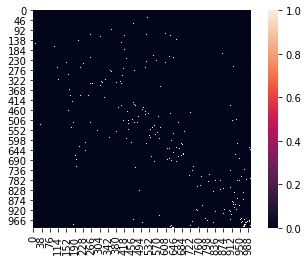

In [86]:
plot = sns.heatmap(data_full.adj, square=True)

The block-structure of the communities is quite apparent. In fact, we can note the fractal block-structure, due to the Kronecker structure of the SBM model. Especially when the population is made to follow a uniform distribution.

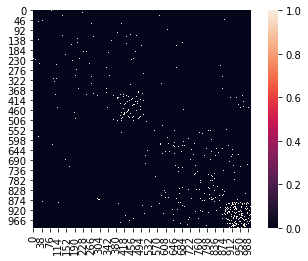

In [87]:
plot = sns.heatmap(data_full_uni.adj, square=True)

For the planted partition model, we do see a block structure, but it's not as rich as the full model.

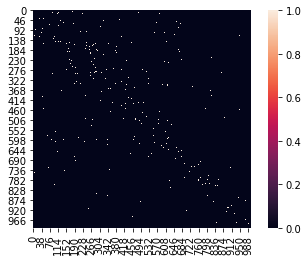

In [88]:
plot = sns.heatmap(data_ppc.adj, square=True)

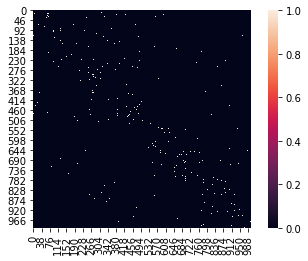

In [89]:
plot = sns.heatmap(data_ppc_uni.adj, square=True)

### Eigenvalues

We can easily compute the eigenvalues of the adjacency matrix. Since we have generated an undirected graph, it will have real eigenvalues. We would like to test how close the eigenspectrum of adjacency matrix is to the eigenspectrum of the expected adjacency matrix (= eigenspectrum of $\Pi\Psi$).

C:\Users\lenovo\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


eigs pipsi full
 [7.974115477736083, 6.949546443383651, 3.3754254670111066, 2.9417276580290386, 1.6941435734597903, 1.4764683905557592, 0.48116562318788203, 0.4193421646124936]
eigs adj top-10 [9.059336398205724, 6.927339587427406, 5.717262396465161, 5.256082382726751, 5.189762109192868, 5.027200977341099, 4.915350046836964, 4.844982350395266, 4.746871126286123, 4.709717846640803]


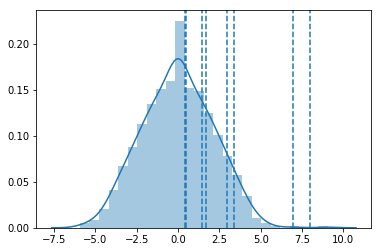

In [94]:
adje = data_full.eigvals()
plot = sns.distplot(adje)
eigs = model_full.eigvals_pipsi()
[plt.gca().axvline(i, ls='--') for i in eigs]
print('eigs pipsi full\n', eigs)
print('eigs adj top-10\n', adje[:10])

C:\Users\lenovo\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


eigs pipsi full uni
 [22.012913086127924, 9.040801552518083, 4.515694823001261, 1.998371375020705, 1.8546159977442902, 0.8895184279109707, 0.820740033775004, 0.3653291844012588]
eigs adj top-10
 [22.200245502786345, 10.070787464806576, 8.325784307080282, 8.046957514902202, 7.824046456234791, 7.715417895418247, 7.584924003048472, 7.403544483498261, 7.349618836904194, 7.293704363605583]


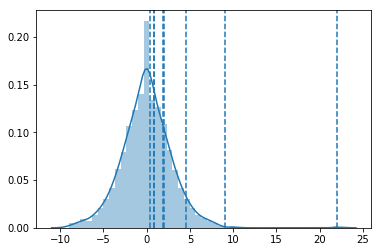

In [95]:
adje = data_full_uni.eigvals()
plot = sns.distplot(adje)
eigs = model_full.eigvals_pipsi(pi='uni')
[plt.gca().axvline(i, ls='--') for i in eigs]
print('eigs pipsi full uni\n', eigs)
print('eigs adj top-10\n', adje[:10])

C:\Users\lenovo\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


eigs pipsi ppc
 [5.6186374431450865, 2.8212818090140863, 2.315919906052594, 1.9547521038582532, 1.3246157546987827, 1.162890962123092, 0.8057201331341767, 0.5459871766455583]
eigs adj top-10
 [6.589619716606132, 4.985336686745687, 4.894831189596206, 4.856890103165404, 4.802088572660106, 4.763487541451036, 4.71260646960192, 4.668032414135106, 4.644298970013113, 4.5779292266246525]


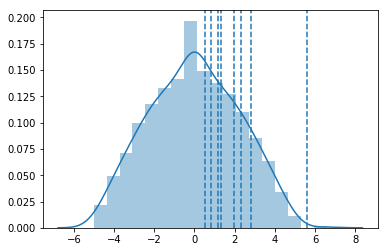

In [96]:
adje = data_ppc.eigvals()
plot = sns.distplot(adje)
eigs = model_ppc.eigvals_pipsi()
[plt.gca().axvline(i, ls='--') for i in eigs]
print('eigs pipsi ppc\n', eigs)
print('eigs adj top-10\n', adje[:10])

In particular, for the planted partition model with a uniform testing population, the eigenvalues of the expected adjacency matrix can be written in closed-form.

C:\Users\lenovo\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


eigs pipsi ppc uni (closed-form)
 [4.311263632311059, 3.031799862396125, 1.8018224998783894, 1.8018224998783892, 1.801822499878388, 1.2670914314430872, 1.2670914314430868, 1.2670914314430866]
eigs adj top-10
 [5.535701599695652, 4.749246649152036, 4.518301197668974, 4.436837875600386, 4.365047796651121, 4.31777454482286, 4.295853440009558, 4.238736416034244, 4.202067317730374, 4.180384055711008]


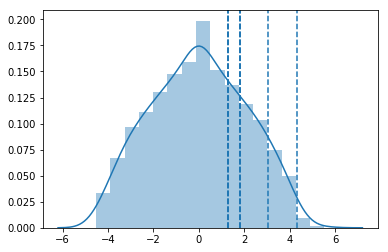

In [103]:
adje = data_ppc_uni.eigvals()
plot = sns.distplot(adje)
eigs = model_ppc.eigvals_pipsi(pi='uni')
[plt.gca().axvline(i, ls='--') for i in eigs]
print('eigs pipsi ppc uni (closed-form)\n', eigs)
print('eigs adj top-10\n', adje[:10])

We see a fair agreement of top eigenvalues.